In [48]:
import numpy as np
import pandas as pd
import cv2

from scipy import ndimage

%matplotlib notebook
import matplotlib.pyplot as plt
cv2.imshow = plt.imshow

from matplotlib import gridspec

import time
from datetime import datetime

from tqdm.notebook import tqdm

# Les histogrammes

#### Plan

 1. Importation d'une image
 1. Visualisation d'un histogramme
 1. Évolution des 3 couleurs le long d'une ligne
 1. Recadrage et concatenation
 1. Blending (ajout d'une image sur une autre)
 1. Enregistrement d'une image
 1. Exercice 1
 1. Exercice 2

## Importation d'une image

En plus de l'importation, nous rédusions les dimensions pour alléger les calculs des histogrammes.

<IPython.core.display.Javascript object>


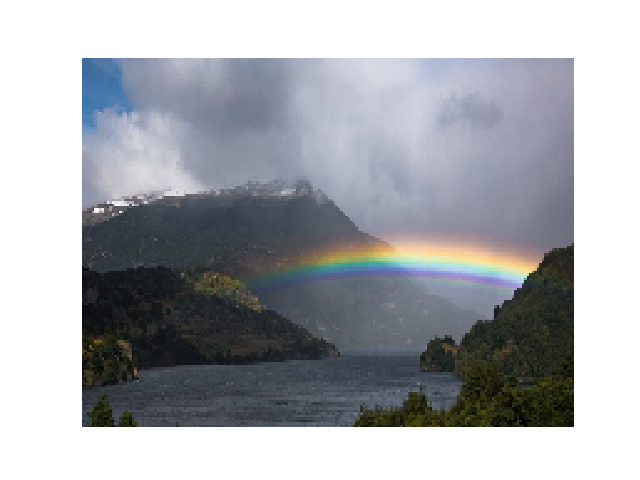

In [91]:
image = cv2.imread("../data/images/rainbow.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, None, fx=0.2, fy=0.2)

plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()

## Affichage des histogrammes

Les histogrammes sont calculés avec la fonction fournie par OpenCV. Nous avons choisi d'afficher une courbe dans le graphique et non un histogramme pour pouvoir en afficher plusieurs facilement.

<IPython.core.display.Javascript object>


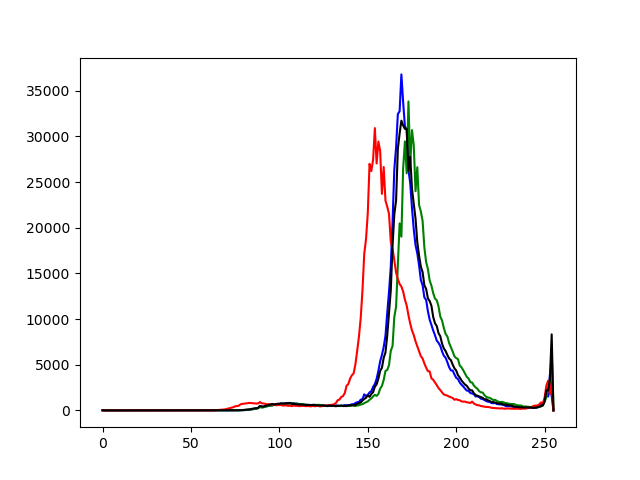

In [45]:
plt.figure()
num_pixels = image.shape[0] * image.shape[1]

for i, color in enumerate(["blue", "green", "red"]):
    hist = cv2.calcHist([image], [i], None, [256], [0, 255], accumulate=0)
    plt.plot(hist, color=color)

img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hist = cv2.calcHist([img], [0], None, [256], [0, 255], accumulate=0)
plt.plot(hist, color="black")
plt.show()

## Classifieur à partir de l'histogramme

L'histogramme de chaque image est calculé pour ensuite être comparé à l'histogramme de la "probe". Celui qui possède la plus petite distance est choisi.

Les 4 mesures donnent des résultats tous très différents. Il est impossbile d'en choisir un avec ces données.

[95457.31296224777, 90840.95252238563, 105525.82577092826, 190472.95251841636, 113023.55901709698, 128482.63091215906]
90840.95252238563


<IPython.core.display.Javascript object>


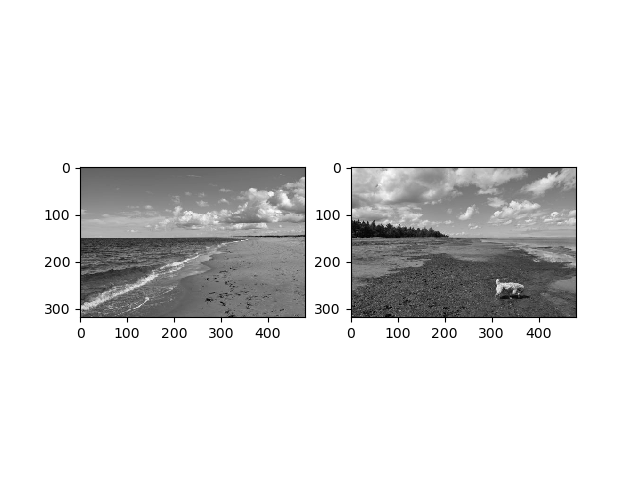

In [77]:
DATA_FOLDER = "../data/datasets/messy_pictures/"

def imread(path):
    return cv2.imread(DATA_FOLDER + path, cv2.IMREAD_GRAYSCALE),

probe = imread("waves.jpg")
data = [
    imread("beach.jpg"),
    imread("dog.jpg",),
    imread("polar.jpg"),
    imread("bear.jpg"),
    imread("lake.jpg"),
    imread("moose.jpg"),
]

hist_prob = cv2.calcHist(probe,[0],None,[256],[0,255])

results = []
for image in data:
    hist = cv2.calcHist(image,[0],None,[256],[0,256])
    distance = cv2.compareHist(hist, hist_prob, cv2.HISTCMP_CHISQR)
    results.append(distance)
    
best_idx = np.argmin(results)
print(results)
print(results[best_idx])

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(probe[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(data[best_idx][0], cmap="gray")
plt.show()

## Recherche dans une image

L'objectif était de retrouver plusieurs feux de circulation dans une image. Pour faire cette recherche, nous avons extrait un feu de circulation dans une image. Ensuite nous avons fait une comparaison d'histogramme à travers toute l'image. Après plusieurs tentatives, c'est la distance de Bhataacharyya qui fonctionne le mieux.

Cette méthode montre très rapidement ses limites. Le seuil pour choisir si une partie de l'image correspond à l'image recherchée est à adapter chaque fois.

<IPython.core.display.Javascript object>


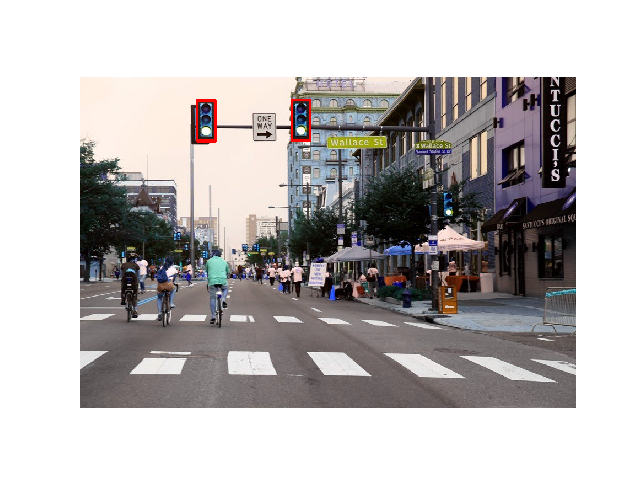

In [87]:
street_c = cv2.imread("../data/images/street.jpg")
street_g = cv2.cvtColor(street_c, cv2.COLOR_BGR2GRAY)
traffic_light = cv2.imread("../data/images/traffic_light.jpg", cv2.IMREAD_GRAYSCALE)

h, w = traffic_light.shape

# threshold option, where if something is maybe an 80% match, then we say it's a match.
res = cv2.matchTemplate(traffic_light, street_g, cv2.HISTCMP_BHATTACHARYYA)
threshold = 0.9
loc = np.where( res >= threshold)

# marking all the matches on the original image, using the cordinates found in gray image.
for pt in zip(*loc[::-1]):
    cv2.rectangle(street_c, pt, (pt[0] + w, pt[1] + h), (255,0,0), 2)
    
plt.figure()
plt.axis("off")
plt.imshow(street_c)
plt.show()
    


# Création d'un dataset

L'idée est de partir d'une image et d'obtenir des valeurs numériques. Par exemple, elles pourront servir pour un algorithme de machine learning.

Les étapes :
 1. Visualisation de l'image
 1. Analyse des histogrammes
 1. Binarisation de l'image
 1. Labélisation
 1. Observation des résultats

<IPython.core.display.Javascript object>


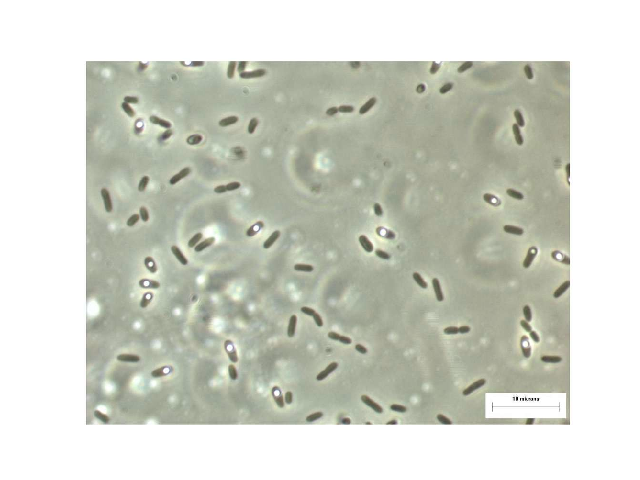

In [3]:
image = cv2.imread("../data/images/bacteries.jpg")
plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


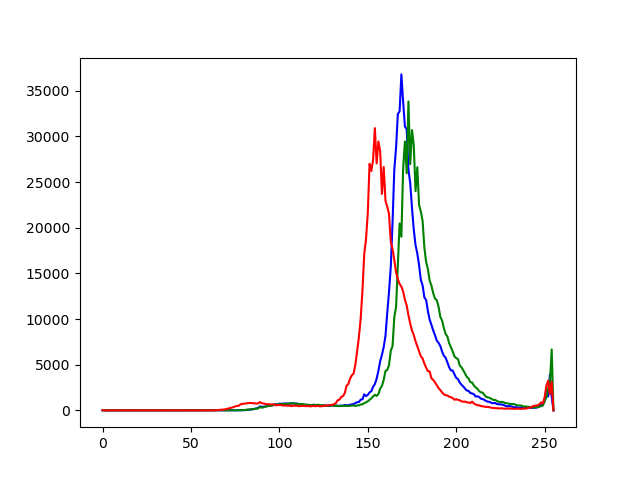

<IPython.core.display.Javascript object>


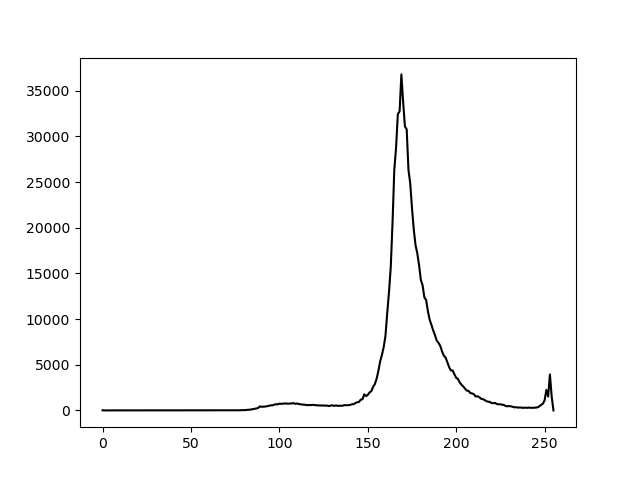

In [46]:
plt.figure()
for i, color in enumerate(["blue", "green", "red"]):
    hist = cv2.calcHist([image], [i], None, [256], [0, 255], accumulate=0)
    plt.plot(hist, color=color)
plt.show()

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure()
hist = cv2.calcHist([image], [0], None, [256], [0, 255], accumulate=0)
plt.plot(hist, color="black")
plt.show()

## Binarisation

C'est à travers cette étape que nous allons extraire les bacteries du fond. Dans cette partie, scipy.ndimage sera utilisé au lieu d'opencv.

Avec un seuil choisi avec l'histogramme, nous séléctionnons les bactéries. Ensuite nous supprimons les artefacts. A ce stade, certaines bactéries avaient un noyau clair alors nous remplissons tous les trous.

<IPython.core.display.Javascript object>


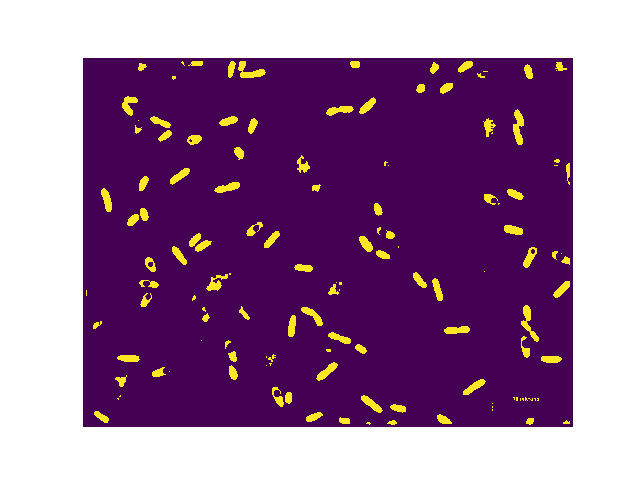

<IPython.core.display.Javascript object>


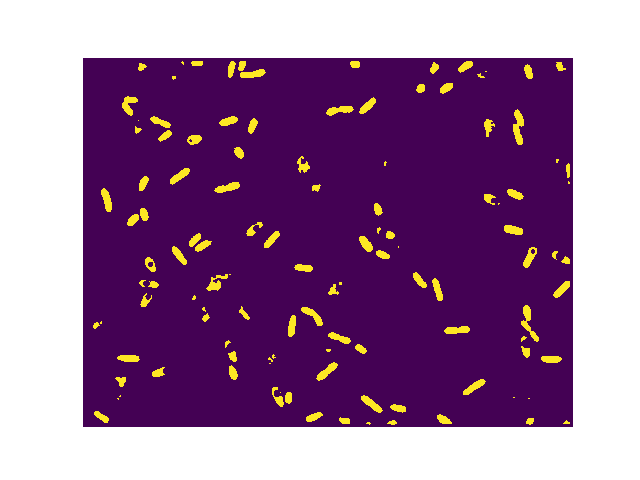

<IPython.core.display.Javascript object>


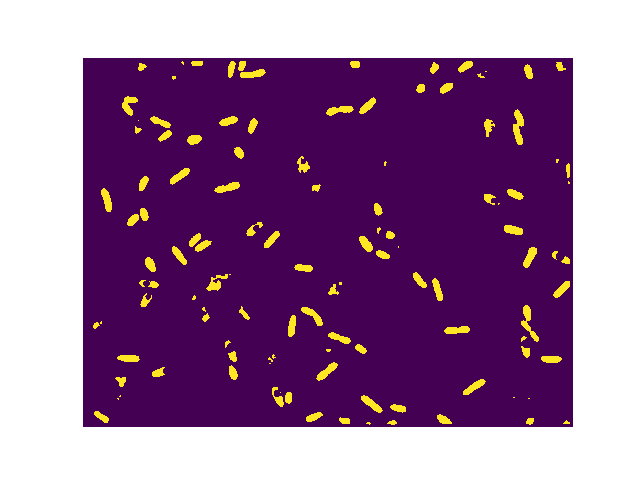

In [28]:
black = gray_image < 150

plt.figure()
plt.axis("off")
plt.imshow(black)
plt.show()

black = ndimage.binary_opening(black)

plt.figure()
plt.axis("off")
plt.imshow(black)
plt.show()

black = ndimage.binary_fill_holes(black)

plt.figure()
plt.axis("off")
plt.imshow(black)
plt.show()

## Labelisation

Grâce à _ndimage.label_, chaque zone colorée devient un label caractérisé par la taille de la surface. Ce qui nous donne le nombre de bactéries ainsi que leur taille.

119


<IPython.core.display.Javascript object>


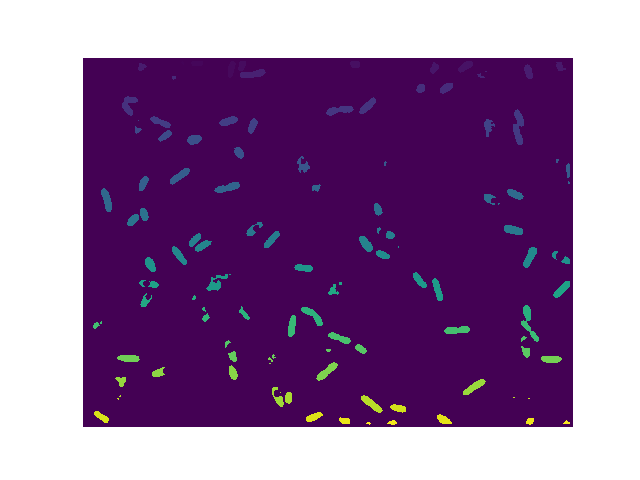

In [29]:
label_image, n_labels = ndimage.label(black)

print(n_labels)
plt.figure()
plt.axis("off")
plt.imshow(label_image)
plt.show()

## Observation

Après avoir enlevé les impurtées réstantes, nous affichons l'histogramme des tailles des bactéries.

(108,)


<IPython.core.display.Javascript object>


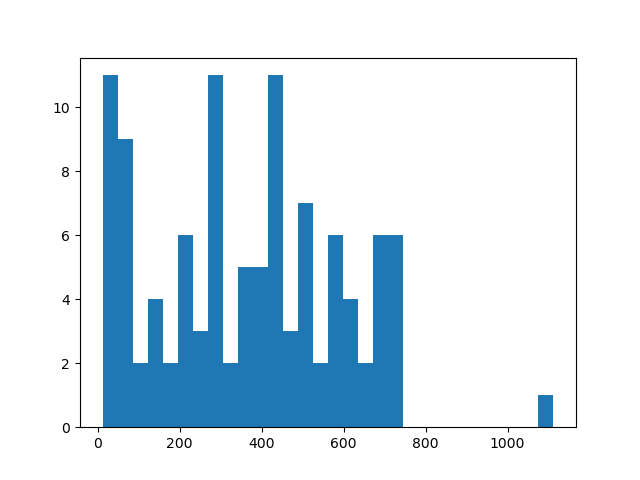

In [78]:
res = ndimage.sum(black, label_image, range(n_labels))

res = res[res > 10]

print(res.shape)

plt.figure()
plt.hist(res, bins=30)
plt.show()